# Маркетинговые кампании португальских банков и их успешность
Данные взяты [отсюда](#https://archive.ics.uci.edu/ml/datasets/Bank%20Marketing). Весят больше 5 Мб, так что не выкладываю в репозиторий.

Датасет содержит информацию о прямых маркетинговых кампаниях (звонки) португальских банков и о том, согласился ли человек сделать депозит.


Классическая задача для прогнозирования в банках - скоринг клиентов для выявления людей с высокой вероятностью дефолта кредита (то есть неплатежа). Долгое время этот анализ осуществлялся с помощью статистических методов, но машинное обучение постепенно начинает играть всё большую роль. Появляются и другие задачи. Так я, работая в банке, занимался предсказанием вероятности отклика клиентов на банковское кросс-сейл предложение.

В данном случае стоит задача предсказания вероятности успеха звонка. Основная цель - снизить количество звонков. Известно, что большинство холодных звонков завершаются неудачами. Если есть возможность определить каким людям "лучше" звонить, то это снизит расходы на маркетинговые кампании.

## Переменные:

### Данные о клиентах:

1. age: возраст.
2. job: типа работы ('admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown').
3. marital: семейное положение ('divorced','married','single','unknown'; примечание: 'divorced' означает разведённость или вдовство).
4. education: образование. ('basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown').
5. default: есть ли кредит в состоянии дефотла ('no','yes','unknown').
6. housing: наличие ипотеки ('no','yes','unknown').
7. loan: есть ли активные займы ('no','yes','unknown').

### Связанное с прошлой маркетинговой компанией:
8. contact: как связывались ('cellular','telephone'), видимо стационарный телефон или мобильник.
9. month: в какой месяц связывались в последний раз.
10. day_of_week: в какой день недели связывались в последний раз.
11. duration: сколько времени (в секундах) говорили при прошлом звонке. Эту переменную нельзя использовать в анализе потому, что для новых звонков это значение будет неизвестно. И при окончании звонка будет известен результат = целевая переменная.

### Другие параметры:
12. campaign: сколько раз с клиентом связывались во время текущей кампании (учитывая последний контакт).
13. pdays: количество дней прошедших с последнего контакта прошлой кампании. 999 - не было такого контакта.
14. previous: количество контактов с этим клиентом до этой кампании.
15. poutcome: результат прошлой кампании. ('failure','nonexistent','success')

### Макроэкономика
16. emp.var.rate: employment variation rate - квартальный индикатор (numeric).
17. cons.price.idx: consumer price index - месячный индикатор (numeric).
18. cons.conf.idx: consumer confidence index - месячный индикатор (numeric).
19. euribor3m: euribor 3 month rate - дневной индикатор (numeric).
20. nr.employed: number of employees - месячный индикатор (numeric).

Целевая переменная:
21. y - has the client subscribed a term deposit? (binary: 'yes','no')

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, StratifiedKFold, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn import preprocessing
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import pandas_profiling

pd.set_option("display.max_columns", 30)

D:\Programs\Anaconda3\lib\site-packages\matplotlib\__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
data = pd.read_csv('data/bank-additional-full.csv', sep=';')

## Общая информация о датасете

Есть такая библиотека - pandas_profiling. Её можно использовать для анализа данных - она подобна 'describe', но выдаёт ещё больше статистики по данным, плюс показывает гистограммы распределений.

In [3]:
pandas_profiling.ProfileReport(data)

Number of variables,21
Number of observations,41188
Total Missing (%),0.0%
Total size in memory,6.6 MiB
Average record size in memory,168.0 B
Numeric,8
Categorical,11
Date,0
Text (Unique),0
Rejected,2
Distinct count,78


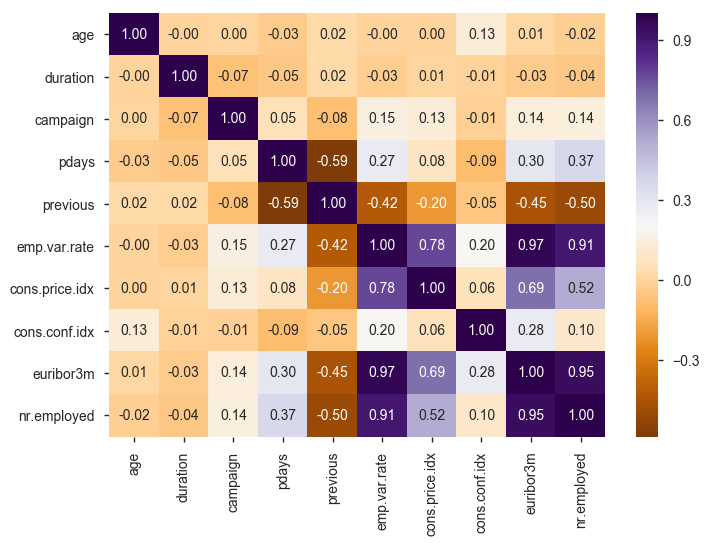

In [4]:
sns.heatmap(data.corr(), annot=True, fmt = ".2f", cbar = True, cmap='PuOr')

Из этого отчёта можно сделать следующие выводы:

* Пропущенных значений нет, зато есть 12 строк с дупликатами;
* 11 переменных являются категориальными и 10 вещественными;
* 3 переменные - euribor3m, emp.var.rate, nr.employed сильно скоррелированы. Но причина может быть в том, что эти показатели меняются не слишком часто и не слишком сильно. В дальнейшем решим, что делать с этими переменными;
* Максимальный возраст - 98. Много, но в пределах возможного;
* Большинству людей звонили 1-2 раза (переменная campaign), а людей, которым делали не больше 5 звонков больше 90%. Но есть отдельные случаи, когда звонили больше 40 и даже больше 50 раз. Если использовать эту переменную как вещественную, то выбросы будут слишком сильными, поэтому лучше относиться к ней как к категориальной и преобразовать. Это же релевантно и для переменной previous;
* Есть категориальные переменные, у которых слишком мало значений по одной из категорий, значит необходимо объединять некоторые из этих категорий. В числе таких переменных default, education, housing, job, loan, marital, month, poutcome;
* У переменной pdays одна из категорий имеет 96% значений, то есть этим клиентам ни разу не звонили. Переменную стоит преобразовать в бинарную или вообще отбросить;
* Ну и, конечно, стоит отменить, что у целевой переменной 88,7% значений - "yes", а остальные - "no"; значит у нас дисбаланс классов;

## Обработка и трансформация признаков.

### Categorical
Для начала сразу закодируем целевую переменную для удобства.

In [5]:
le = preprocessing.LabelEncoder()
data['y'] = le.fit_transform(data['y'])

В банковской сфере есть немало своих способов анализа переменных. Один из них - расчёт показателя Information Value (IV). Он используется для оценки важности категориальных признаков - чем лучше переменная помогает "дискриминировать" целевую переменную, тем выше IV. [Здесь](#http://ucanalytics.com/blogs/information-value-and-weight-of-evidencebanking-case/) приводится хороший пример того, как рассчитывается этот показатель. А функция ниже реализовывает его расчёт.

При этом использовать его следует аккуратно. Слишком высокие значения (больше 0.5) скорее подозрительны, чем очень хороши.

In [6]:
def calc_iv(data, target, feature):
    df = pd.DataFrame(index = data[feature].unique(),
                      data={'% responders': data.groupby(feature)[target].sum() / np.sum(data[target])})
    df['% non-responders'] = (data.groupby(feature)[target].count() - data.groupby(feature)[target].sum()) / (len(data[target]) - np.sum(data[target]))
    df['WOE'] = np.log(df['% responders'] / df['% non-responders'])
    df['DG-DB'] = df['% responders'] - df['% non-responders']
    df['IV'] = df['WOE'] * df['DG-DB']
    return df, np.sum(df['IV'])

In [7]:
calc_iv(data, 'y', 'job')[0]

,% responders,% non-responders,WOE,DG-DB,IV
housemaid,0.022845,0.026103,-0.133312,-0.003258,4.343096e-04
services,0.069612,0.099759,-0.359822,-0.030147,1.084759e-02
admin.,0.291379,0.248167,0.160525,0.043213,6.936681e-03
blue-collar,0.137500,0.235745,-0.539126,-0.098245,5.296630e-02
technician,0.157328,0.164523,-0.044722,-0.007196,3.218128e-04
retired,0.093534,0.035187,0.977665,0.058348,5.704466e-02
management,0.070690,0.071030,-0.004801,-0.000340,1.633538e-06
unemployed,0.031034,0.023804,0.265232,0.007230,1.917674e-03
self-employed,0.032112,0.034804,-0.080487,-0.002691,2.166298e-04
unknown,0.007974,0.008017,-0.005343,-0.000043,2.282177e-07


In [8]:
print(calc_iv(data, 'y', 'job')[1])

0.18871287107835757


А следующая функция будет использоваться для того, чтобы показать взаимосвязь категориальных переменных с целевой. Она показывает количества по категориям (абсолютные и относительные), а также показывает график на котором отображены количества по категориям и среднее значение целевой переменной. Также отображается IV.

In [9]:
def feature_stat(data_, feature, target_name):
    data = data_.copy()
    print('Counts:')
    print(data.groupby(feature)[target_name].count().sort_values(ascending=False))
    print('Frequencies:')
    print(data[feature].value_counts(normalize=True, dropna=False))
    x = [i for i in data.groupby(feature)[target_name].count().index]
    
    if data[feature].isnull().any():
        if str(data[feature].dtype) == 'category':
            data[feature].cat.add_categories(['None'], inplace=True)
        data[feature].fillna('None', inplace=True)
        
    y1 = [i for i in data.groupby(feature)[target_name].count().values]
    y2 = [i for i in data.groupby(feature)[target_name].mean().values]
    ind = np.arange(len(data[feature].unique()))
    fig, ax1 = plt.subplots(figsize=(4, 3))
    ax1.bar(ind, y1, align='center', width=0.4, alpha=0.7)
    ax1.set_xlabel(feature)
    ax1.set_ylabel('Counts', color='b')
    ax1.tick_params('y1', colors='b')
    ax2 = ax1.twinx()
    ax2.plot(ind, y2, 'r')
    ax2.set_ylabel('Mean rate', color='r')
    ax2.tick_params('y2', colors='r')
    plt.xticks(ind, x, rotation=45)
    ax1.set_xticklabels(x, rotation=35)
    plt.grid(False)
    plt.show()
    _, iv = calc_iv(data, target_name, feature)
    print('IV: ', iv)

Кстати говоря, здесь удобно использовать виджеты - я делаю выпадающий список из релевантных переменных и могу смотреть график для нужной, а не прокручивать экран в поисках интересующего меня графика.

In [10]:
from ipywidgets import interact, interactive, interact_manual
def a(feature):
    feature_stat(data, feature, 'y')
    
cats = ['housing', 'marital', 'education', 'default', 'job', 'loan',
       'contact', 'month', 'day_of_week']
interact(a, feature=cats)

A Jupyter Widget

<function __main__.a>

Дальше рассмотрим переменные, которые требуют отдельного внимания.

### Job

Counts:
job
admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: y, dtype: int64
Frequencies:
admin.           0.253035
blue-collar      0.224677
technician       0.163713
services         0.096363
management       0.070992
retired          0.041760
entrepreneur     0.035350
self-employed    0.034500
housemaid        0.025736
unemployed       0.024619
student          0.021244
unknown          0.008012
Name: job, dtype: float64


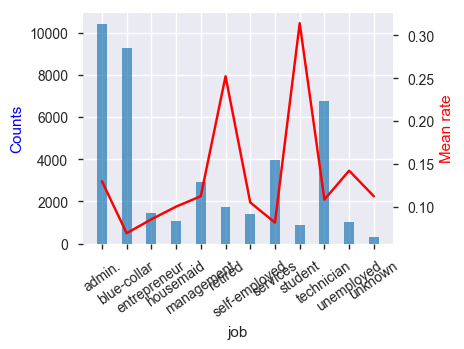

IV:  0.18871287107835757


In [11]:
feature_stat(data, 'job', 'y')

Видно, что есть несколько категорий, в которых слишком мало значений. Это приводит к нестабильности. Одним из решений будет объединений таких маленьких категорий. Я объединю все категории, в которых меньше 5% значений.

In [12]:
z = data['job'].value_counts(normalize=True, dropna=False)
to_remove = [e for i, e in enumerate(z.index) if z.values[i] < 0.05]
data.loc[data['job'].isin(to_remove) == True, 'job'] = 'Others'

### marital

Counts:
marital
married     24928
single      11568
divorced     4612
unknown        80
Name: y, dtype: int64
Frequencies:
married     0.605225
single      0.280859
divorced    0.111974
unknown     0.001942
Name: marital, dtype: float64


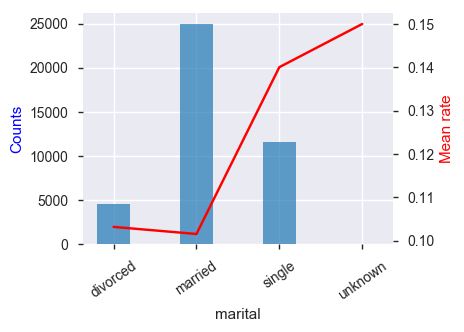

IV:  0.028215132169045226


In [13]:
feature_stat(data, 'marital', 'y')

In [14]:
# Объединим unknown и single, к тому же они скорее всего одинаковы.
data.loc[data['marital'] == 'unknown', 'marital'] = 'single'

### education

Counts:
education
university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
unknown                 1731
illiterate                18
Name: y, dtype: int64
Frequencies:
university.degree      0.295426
high.school            0.231014
basic.9y               0.146766
professional.course    0.127294
basic.4y               0.101389
basic.6y               0.055647
unknown                0.042027
illiterate             0.000437
Name: education, dtype: float64


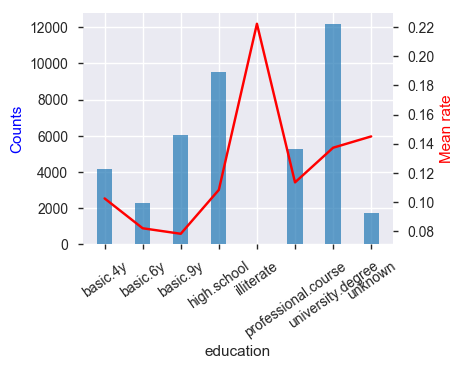

IV:  0.048576408429404055


In [15]:
feature_stat(data, 'education', 'y')

У двух категорий совсем мало значений, объединю их с самым низшим уровнем образования.

In [16]:
data.loc[data['education'].isin(['unknown', 'illiterate']) == True, 'education'] = 'basic.4y'

### default

Counts:
default
no         32588
unknown     8597
yes            3
Name: y, dtype: int64
Frequencies:
no         0.791201
unknown    0.208726
yes        0.000073
Name: default, dtype: float64


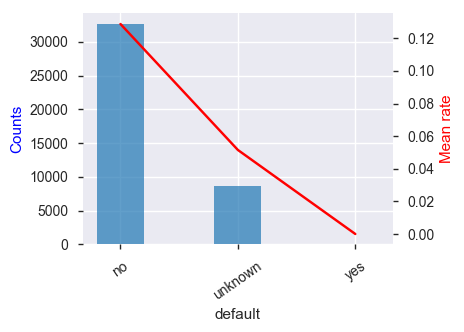

IV:  inf


D:\Programs\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: RuntimeWarning: divide by zero encountered in log


In [17]:
feature_stat(data, 'default', 'y')

In [18]:
#Отсутствие информации может означать как отсутствие дефолта, так и попытку его сокрытия. Объединю меньшие категории.
data.loc[data['default'] == 'yes', 'default'] = 'unknown'

### housing

Counts:
housing
yes        21576
no         18622
unknown      990
Name: y, dtype: int64
Frequencies:
yes        0.523842
no         0.452122
unknown    0.024036
Name: housing, dtype: float64


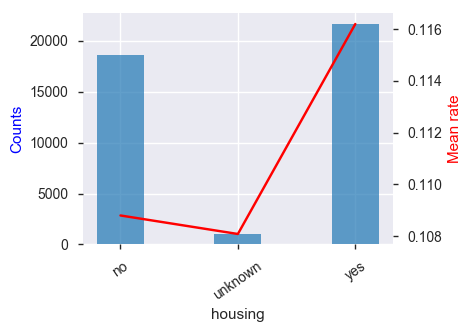

IV:  0.0013830459854570329


In [19]:
feature_stat(data, 'housing', 'y')

Заодно хочу заметить: видно, что IV очень маленький. Это неудивительно: разница в среднем значении целевой переменной по категориям всего лишь 0.008.

In [20]:
data.loc[data['housing'] == 'unknown', 'housing'] = 'no'

### loan

Counts:
loan
no         33950
yes         6248
unknown      990
Name: y, dtype: int64
Frequencies:
no         0.824269
yes        0.151695
unknown    0.024036
Name: loan, dtype: float64


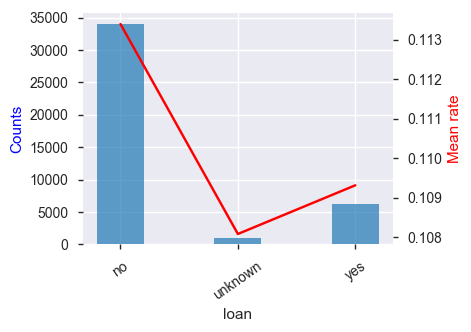

IV:  0.0002687348080584902


In [21]:
feature_stat(data, 'loan', 'y')

In [22]:
data.loc[data['loan'] == 'unknown', 'loan'] = 'no'

### contact

Counts:
contact
cellular     26144
telephone    15044
Name: y, dtype: int64
Frequencies:
cellular     0.634748
telephone    0.365252
Name: contact, dtype: float64


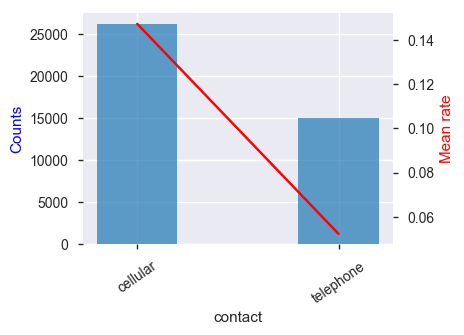

IV:  0.2516629426643363


In [23]:
feature_stat(data, 'contact', 'y')

Здесь просто хочу отметить, что эта переменная является весьма хорошей - 2 категории со значительно различающимися значениями целевой переменной.

### month

Counts:
month
may    13769
jul     7174
aug     6178
jun     5318
nov     4101
apr     2632
oct      718
sep      570
mar      546
dec      182
Name: y, dtype: int64
Frequencies:
may    0.334296
jul    0.174177
aug    0.149995
jun    0.129115
nov    0.099568
apr    0.063902
oct    0.017432
sep    0.013839
mar    0.013256
dec    0.004419
Name: month, dtype: float64


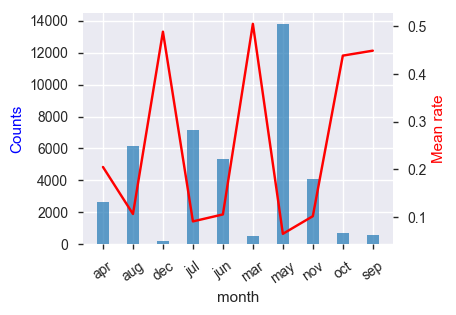

IV:  0.4851166812939728


In [24]:
feature_stat(data, 'month', 'y')

Я долго думал, что делать с этой переменной, в итоге решил объединять категории по тому же принципу, что и в job.

In [25]:
z = data['month'].value_counts(normalize=True, dropna=False)
to_remove = [e for i, e in enumerate(z.index) if z.values[i] < 0.05]
data.loc[data['month'].isin(to_remove) == True, 'month'] = 'Others'

Counts:
month
may       13769
jul        7174
aug        6178
jun        5318
nov        4101
apr        2632
Others     2016
Name: y, dtype: int64
Frequencies:
may       0.334296
jul       0.174177
aug       0.149995
jun       0.129115
nov       0.099568
apr       0.063902
Others    0.048946
Name: month, dtype: float64


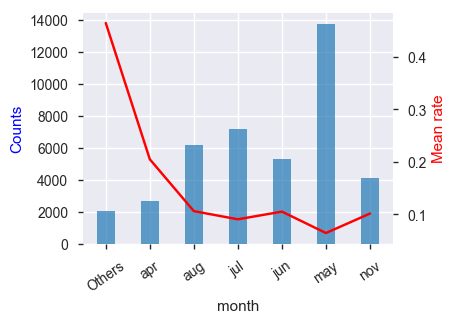

IV:  0.4835859768572557


In [26]:
feature_stat(data, 'month', 'y')

### pdays

In [27]:
#Как и говорил выше - превращаю переменную в бинарную.
data.loc[data['pdays'] != 999, 'pdays'] = 0

Counts:
pdays
999    39673
0       1515
Name: y, dtype: int64
Frequencies:
999    0.963217
0      0.036783
Name: pdays, dtype: float64


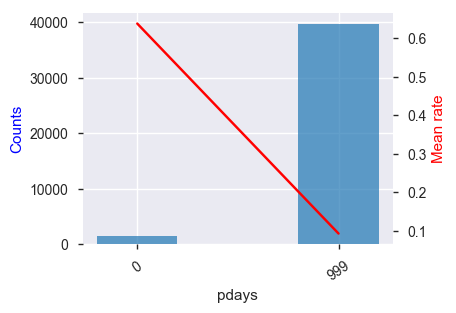

IV:  0.5513057174671154


In [28]:
feature_stat(data, 'pdays', 'y')

На переменную надо будет внимательно смотреть - она может быть слишком нестабильной.

### poutcome

Counts:
poutcome
nonexistent    35563
failure         4252
success         1373
Name: y, dtype: int64
Frequencies:
nonexistent    0.863431
failure        0.103234
success        0.033335
Name: poutcome, dtype: float64


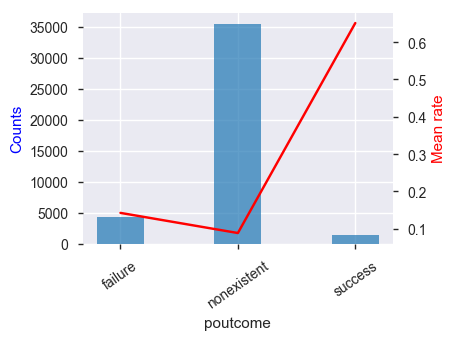

IV:  0.5476707474782461


In [29]:
feature_stat(data, 'poutcome', 'y')

С одной стороны разница между успехом и неуспехом большая не только по смыслу, но и по среднему значению целевой переменной. Если бы это было соревнование, стоило бы всё оставить так, как есть. Но слишком мало клиентов с success, так что объединять категории необходимо. И новая категория будет иметь другой смысл: то, что человеку звонили в рамках прошлой компании.

In [30]:
data.loc[data['poutcome'] != 'nonexistent', 'poutcome'] = 'existent'

Counts:
poutcome
nonexistent    35563
existent        5625
Name: y, dtype: int64
Frequencies:
nonexistent    0.863431
existent       0.136569
Name: poutcome, dtype: float64


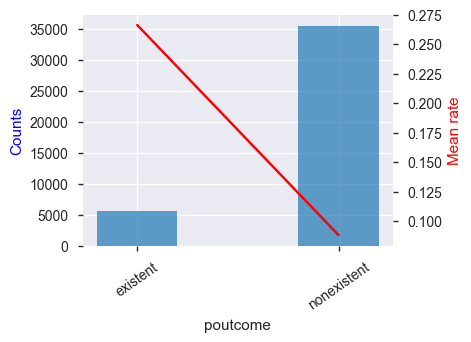

IV:  0.2777966929471697


In [31]:
feature_stat(data, 'poutcome', 'y')

### Campaign

Как уже говорилось, для этой переменной необходимо объединить часть категорий. Для удобства я приравняю все значения больше 5 к 5.

In [32]:
z = data['campaign'].value_counts(normalize=True, dropna=False)
to_remove = [e for i, e in enumerate(z.index) if z.values[i] < 0.05]
data.loc[data['campaign'].isin(to_remove) == True, 'campaign'] = 5

Counts:
campaign
1    17642
2    10570
3     5341
5     4984
4     2651
Name: y, dtype: int64
Frequencies:
1    0.428329
2    0.256628
3    0.129674
5    0.121006
4    0.064363
Name: campaign, dtype: float64


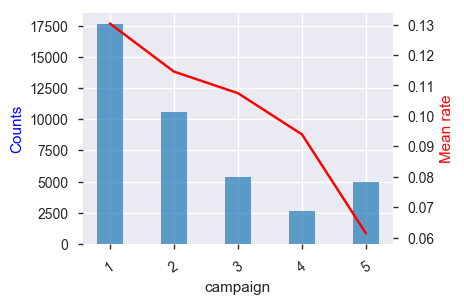

IV:  0.05665796056384939


In [33]:
feature_stat(data, 'campaign', 'y')

### previous

In [34]:
data.loc[data['previous'] > 1, 'previous'] = 1

Counts:
previous
0    35563
1     5625
Name: y, dtype: int64
Frequencies:
0    0.863431
1    0.136569
Name: previous, dtype: float64


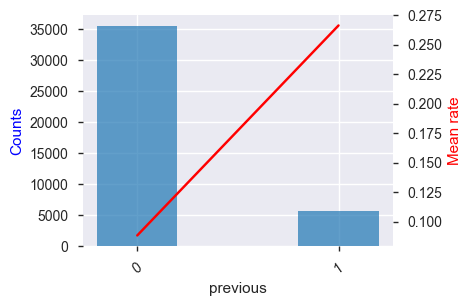

IV:  0.2777966929471697


In [35]:
feature_stat(data, 'previous', 'y')

В итоге имеем бинарную переменную.

## Создание новых переменных.

Есть много разных способов создания новых переменных. Один из них - строить графики и на них искать взаимозависимости переменных.

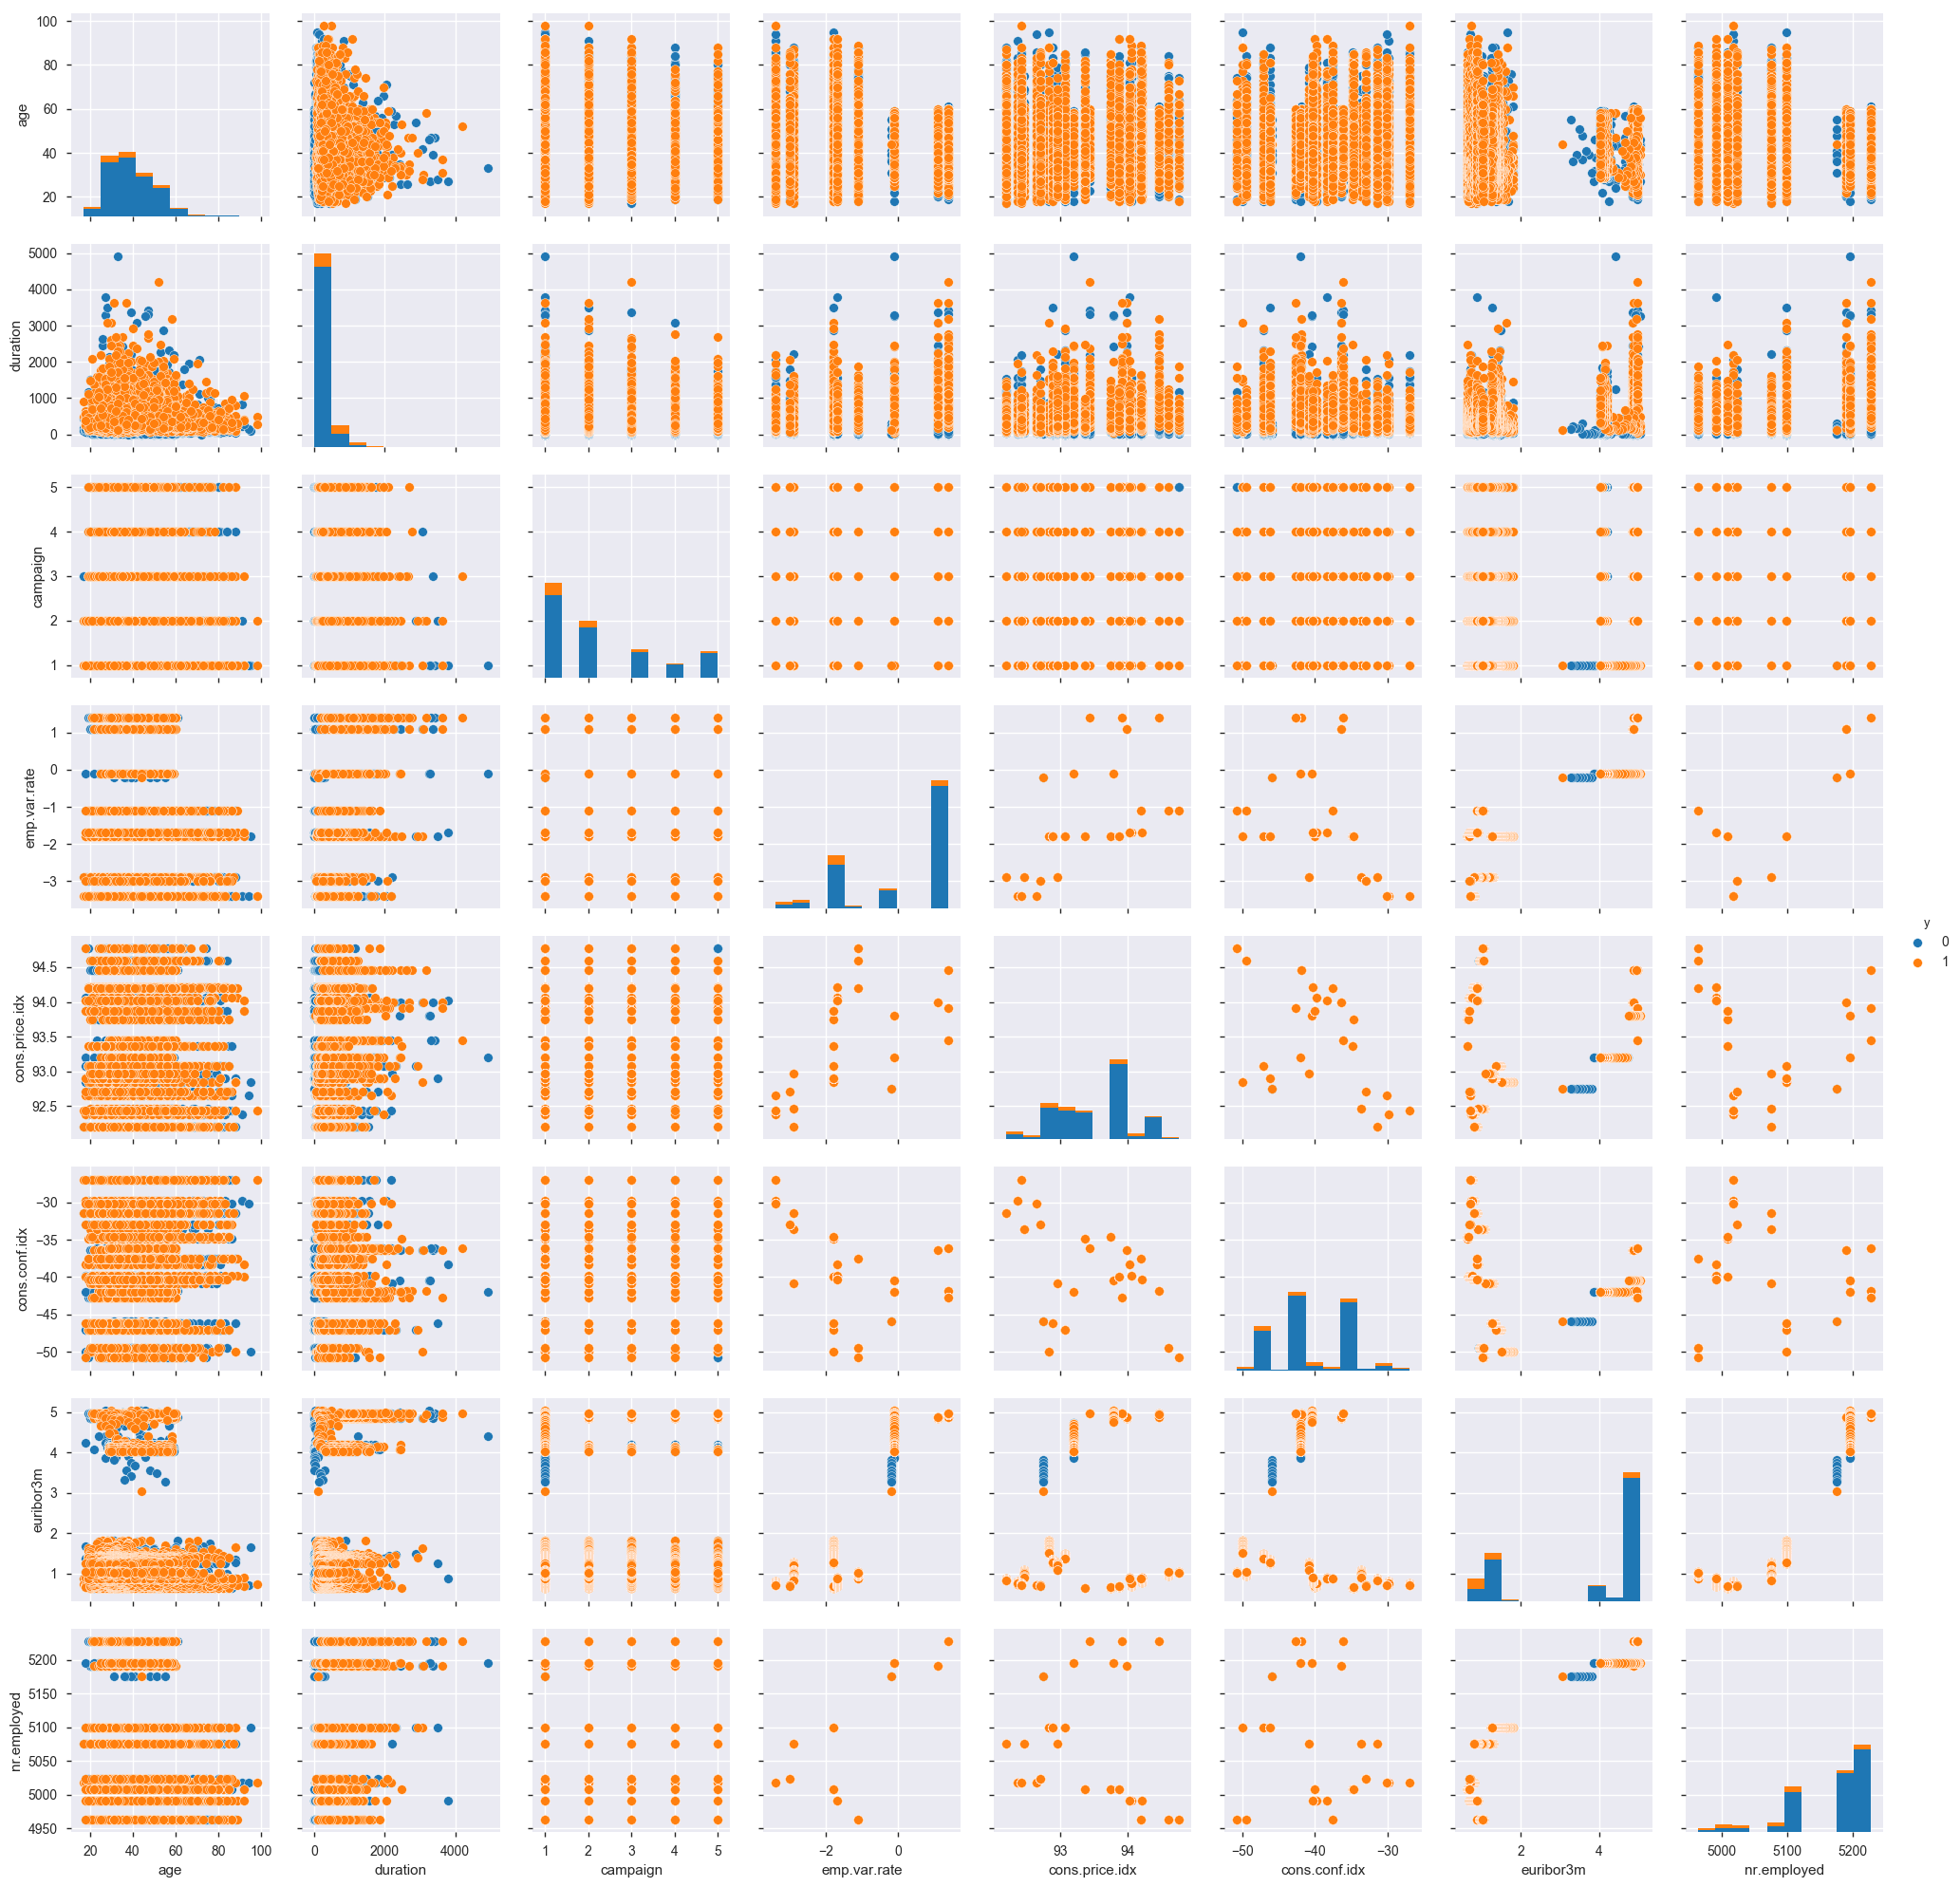

In [36]:
sns.pairplot(data=data, hue='y', vars=['age', 'duration', 'campaign',  'emp.var.rate', 'cons.price.idx',
                                       'cons.conf.idx', 'euribor3m', 'nr.employed'])

Но здесь нужна аккуратность. Может показаться, что переменная duration в сочетании с другими переменными хорошо различает целевую переменную. Но по факту таких значений просто мало, поэтому перекос вполне возможен.

Ещё один вариант - попробовать посмотреть как себя ведут пары категориальных переменных.

In [37]:
pd.crosstab(data.education, data.default)

default,no,unknown
education,,
basic.4y,3671,2254
basic.6y,1441,851
basic.9y,4418,1627
high.school,7904,1611
professional.course,4436,807
university.degree,10718,1450


In [38]:
pd.crosstab(data.education, data.default, values=data.y, aggfunc=np.mean)

default,no,unknown
education,,
basic.4y,0.153364,0.053239
basic.6y,0.096461,0.057579
basic.9y,0.089633,0.047326
high.school,0.120825,0.047176
professional.course,0.124887,0.050805
university.degree,0.148349,0.055172


Здесь можно выделить 3 группы людей - с неизвестным состоянием дефолта, без дефолта и с образованием basic.6y или basic.9y, остальные. Попробуем создать такую переменную.

In [39]:
data['education_default'] = 0
data.loc[(data.default == 'no') & (data.education.isin(['basic.6y', 'basic.9y'])), 'education_default'] = 1
data.loc[(data.default == 'no') & (data.education.isin(['basic.6y', 'basic.9y']) == False), 'education_default'] = 2

Counts:
education_default
2    26729
0     8600
1     5859
Name: y, dtype: int64
Frequencies:
2    0.648951
0    0.208799
1    0.142250
Name: education_default, dtype: float64


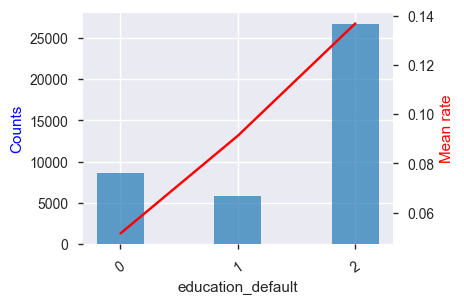

IV:  0.15088109688542925


In [40]:
feature_stat(data, 'education_default', 'y')

Вроде получилась хорошая переменная.

In [41]:
#Вот так выглядит датасет сейчас.
data.head(10)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,education_default
0,56,Others,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,2
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,2
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,1
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,2
5,45,services,married,basic.9y,unknown,no,no,telephone,may,mon,198,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,0
6,59,admin.,married,professional.course,no,no,no,telephone,may,mon,139,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,2
7,41,blue-collar,married,basic.4y,unknown,no,no,telephone,may,mon,217,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,0
8,24,technician,single,professional.course,no,yes,no,telephone,may,mon,380,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,2
9,25,services,single,high.school,no,yes,no,telephone,may,mon,50,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,2


## Выбор моделей, метрики и предобработка данных.

Как уже говорилось, в датасете присутствует дисбаланс классов. Самая распространённая метрика для бинарной классификации с дисбалансом данных - ROC AUC, и именно её я буду использовать.

Существует много алгоритмов, которые подходят для классификации несбалансированных данных, в данном случае я решил попробовать случайные леса и логистическую регрессию.

* RandomForestClassifier - алгоритм, который хорош для классификации, особенно когда имеется много категориальных и вещественных признаков. Для этой модели достаточно закодировать категориальные переменные, нормализовывать данные не нужно;
* LogisticRegressionCV - логистическая регрессия является классической моделью для подобных проблем. А эта вариация позволяет подбирать коэффициент регуляризации на кросс-валидации. Но в данном случае нужно применять one hot encoding для категориальных переменных и нормализовывать вещественные;

Соответственно будет 2 набора данных.

In [43]:
#Отбрасываю дубликаты.
data = data.drop_duplicates()

In [44]:
for col in ['housing', 'loan', 'contact', 'pdays', 'poutcome', 'default']:
    le = preprocessing.LabelEncoder()
    data[col] = le.fit_transform(data[col])
    
for col in ['job', 'marital', 'education', 'month', 'day_of_week', 'campaign', 'education_default']:
    dummies = pd.get_dummies(data[col], drop_first=True, prefix='{}_'.format(col))
    data.drop(col, axis=1, inplace=True)
    data = data.join(dummies)
    
data1 = data.copy()

D:\Programs\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
D:\Programs\Anaconda3\lib\site-packages\ipykernel\__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [45]:
X_rf = data.drop(['duration', 'y'],axis=1)
y_rf = data['y']

Разбиваю данные на тренировочные и валидационные (33%). Для фиксирования результатов задаю random_state, а также stratify, для корректной работы с дисбалансными классами.

In [46]:
X_train_rf, X_valid_rf, y_train_rf, y_valid_rf = train_test_split(X_rf, y_rf, test_size=0.33, random_state=42, stratify=y_rf)

С одной стороны, нормализацию данных для LogisticRegressionCV можно сделать прямо сейчас, но поскольку мы хотим честно провалидироваться, я вначале разделю данные, а уже потом буду нормализировать их.

In [47]:
X_lr = data.drop(['duration', 'y'],axis=1)
y_lr = data['y']
X_train_lr, X_valid_lr, y_train_lr, y_valid_lr = train_test_split(X_lr, y_lr, test_size=0.33, random_state=42, stratify=y_lr)

In [48]:
scaler = StandardScaler()
norm_cols = ['age', 'pdays', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
scaler.fit(X_train_lr[norm_cols])
X_train_lr = scaler.transform(X_train_lr[norm_cols])
X_valid_lr = scaler.transform(X_valid_lr[norm_cols])

### Настройка параметров моделей.

#### LogisticRegressionCV

Для LogisticRegressionCV не так много параметров для настройки. Набор коэффициентов по умолчанию - это числа от 1e-4 до 1e4 в логарифмической шкале. Также стоит указать метрику roc_auc.

In [49]:
lrcv = linear_model.LogisticRegressionCV(n_jobs=-1, scoring='roc_auc')
lrcv.fit(X_train_lr, y_train_lr)

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=-1, penalty='l2', random_state=None,
           refit=True, scoring='roc_auc', solver='lbfgs', tol=0.0001,
           verbose=0)

#### RandomForestClassifier

При настройке гиперпараметров модели необходимо соблюдать баланс между гибкостью и устойчивостью. Отсутствие ограничений по max_features и max_depth обычно повышает гибкость, но стоит пробовать и другие значения. n_estimators - один из основных параметров, который несет похожую смысловую нагрузку. Но большое количество деревьем может требовать слишком больших затрат ресурсов. Критерий определяет принцип разделения для деревьев. Оставшиеся 2 параметра дополнительны, но тоже могут помочь.

In [51]:
forest = RandomForestClassifier(class_weight='balanced', random_state=42)

parameter_grid = {'n_estimators' : [10, 30, 150],
                  'criterion' : ['entropy', 'gini'],
                  'max_features' : ['sqrt', None],
                  'max_depth' : [5, 10, None],
                  'min_samples_split' : [2, 15],
                  'max_leaf_nodes' : [100, None],
                 }

grid_search = GridSearchCV(forest, param_grid=parameter_grid, scoring='roc_auc', cv=StratifiedKFold(3), verbose=2, n_jobs=-1)
grid_search.fit(X_train_rf, y_train_rf)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Fitting 3 folds for each of 144 candidates, totalling 432 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   26.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done 432 out of 432 | elapsed: 12.6min finished


Best score: 0.7925815729368543
Best parameters: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'max_leaf_nodes': 100, 'min_samples_split': 2, 'n_estimators': 150}


In [81]:
forest1 = RandomForestClassifier(class_weight='balanced', 
                                n_estimators=grid_search.best_params_['n_estimators'],
                                max_features=grid_search.best_params_['max_features'],
                                max_depth=grid_search.best_params_['max_depth'],
                                min_samples_split=grid_search.best_params_['min_samples_split'],
                                max_leaf_nodes=grid_search.best_params_['max_leaf_nodes'])
forest1.fit(X_train_rf, y_train_rf)

#### Сравнение моделей

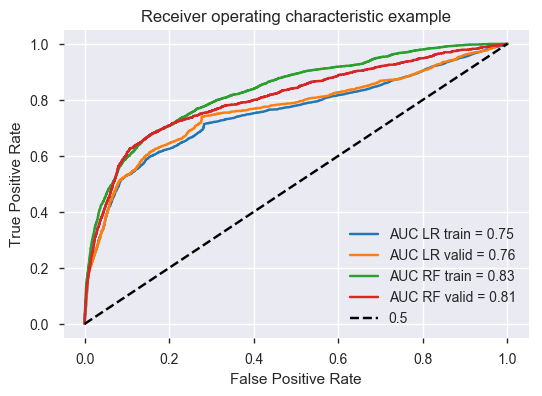

In [89]:
plt.figure(figsize=(6, 4))
y_pred_train_lr = lrcv.predict_proba(X_train_lr)[:, 1]
fpr_train_lr, tpr_train_lr, thresholds_train_lr = roc_curve(y_train_lr, y_pred_train_lr)
plt.plot(fpr_train_lr, tpr_train_lr, label='AUC LR train = %0.2f' % roc_auc_score(y_train_lr, y_pred_train_lr))
y_pred_val_lr = lrcv.predict_proba(X_valid_lr)[:, 1]
fpr_val_lr, tpr_val_lr, thresholds_val_lr = roc_curve(y_valid_lr, y_pred_val_lr)
plt.plot(fpr_val_lr, tpr_val_lr, label='AUC LR valid = %0.2f' % roc_auc_score(y_valid_lr, y_pred_val_lr))

y_pred_train_rf = grid_search.predict_proba(X_train_rf)[:, 1]
fpr_train_rf, tpr_train_rf, thresholds_train_rf = roc_curve(y_train_rf, y_pred_train_rf)
plt.plot(fpr_train_rf, tpr_train_rf, label='AUC RF train = %0.2f' % roc_auc_score(y_train_rf, y_pred_train_rf))
y_pred_val_rf = grid_search.predict_proba(X_valid_rf)[:, 1]
fpr_val_rf, tpr_val_rf, thresholds_val_rf = roc_curve(y_valid_rf, y_pred_val_rf)
plt.plot(fpr_val_rf, tpr_val_rf, label='AUC RF valid = %0.2f' % roc_auc_score(y_valid_rf, y_pred_val_rf))

plt.plot([0, 1], [0, 1], color='black', linestyle='--', label='0.5')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [55]:
scores = cross_val_score(lrcv, X_train_lr, y_train_lr, cv=5, scoring='roc_auc')
print('Cross-validation: mean value is {0} with std {1}.'.format(np.round(np.mean(scores), 4),
                                                                 np.round(np.std(scores), 4)))

Cross-validation: mean value is 0.7522 with std 0.0159.


In [90]:
scores = cross_val_score(forest1, X_train_rf, y_train_rf, cv=5, scoring='roc_auc')
print('Cross-validation: mean value is {0} with std {1}.'.format(np.round(np.mean(scores), 4),
                                                                 np.round(np.std(scores), 4)))

Cross-validation: mean value is 0.7935 with std 0.0115.


RandomForestClassifier оказался значительно лучше. ROC AUC на валидационных данных 0.81, на кросс-валидации 0.79.

Давайте посмотрим на важность признаков:

In [85]:
indices = np.argsort(forest1.feature_importances_)[::-1]

print('Feature ranking:')
for f in range(X_train_rf.shape[1]):
    print('%d. feature %d %s (%f)' % (f + 1, indices[f], X_train_rf.columns[indices[f]],
                                      forest1.feature_importances_[indices[f]]))

Feature ranking:
1. feature 11 euribor3m (0.197996)
2. feature 12 nr.employed (0.180314)
3. feature 8 emp.var.rate (0.158095)
4. feature 10 cons.conf.idx (0.080560)
5. feature 5 pdays (0.062675)
6. feature 9 cons.price.idx (0.062363)
7. feature 0 age (0.033921)
8. feature 4 contact (0.028788)
9. feature 29 month_month__may (0.026658)
10. feature 7 poutcome (0.025207)
11. feature 6 previous (0.015743)
12. feature 40 education_default_education_default__2 (0.013018)
13. feature 1 default (0.011947)
14. feature 38 campaign_campaign__5 (0.008659)
15. feature 14 job_job__blue-collar (0.007227)
16. feature 25 month_month__apr (0.006602)
17. feature 31 day_of_week_day_of_week__mon (0.004965)
18. feature 21 education_education__basic.9y (0.004280)
19. feature 32 day_of_week_day_of_week__thu (0.004274)
20. feature 19 marital_marital__single (0.003976)
21. feature 35 campaign_campaign__2 (0.003919)
22. feature 2 housing (0.003898)
23. feature 24 education_education__university.degree (0.003685)


Топ 3 фичи оказалисись высоко скоррелированными фичами. По идее использование коррелирующих признаков не должно сильно влиять на качество модели. Попробуем проверить.

In [86]:
forest1.fit(X_train_rf.drop(['nr.employed', 'emp.var.rate'], axis=1), y_train_rf)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=10, max_features='sqrt',
            max_leaf_nodes=100, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=150, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [88]:
scores = cross_val_score(forest1, X_train_rf, y_train_rf, cv=5, scoring='roc_auc')
print('Cross-validation: mean value is {0} with std {1}.'.format(np.round(np.mean(scores), 4),
                                                                 np.round(np.std(scores), 4)))

Cross-validation: mean value is 0.7939 with std 0.0124.


Действительно, значение roc_auc на кросс-валидации практически не изменилось.

## Кривые обучения и валидации

In [79]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    '''
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html
    '''
    
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='roc_auc')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

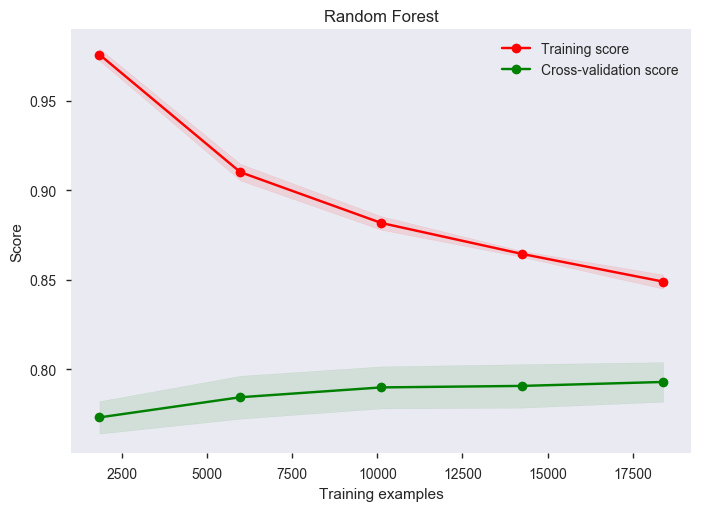

In [60]:
plt.figure(figsize=(6, 4))
plot_learning_curve(forest1, 'Random Forest', X_train_rf, y_train_rf, cv=3, n_jobs=4);

График в целом адекватный, но видно, что данных было недостаточно. Сбор дополнительных данных может привести к улучшению качества прогноза.

Построю кривые валидации для двух параметров.

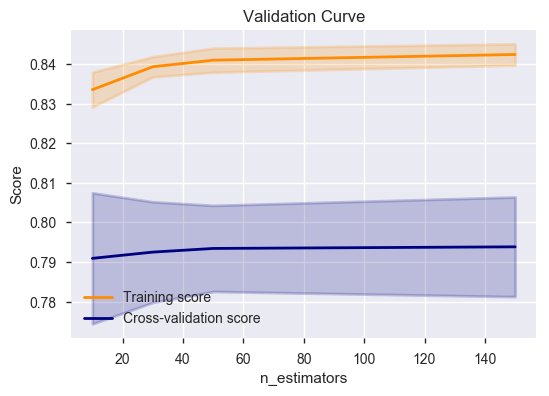

In [74]:
#http://scikit-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html
plt.figure(figsize=(6, 4))
param_range=np.array([10, 30, 50, 150])
train_scores, test_scores = validation_curve(forest1, X_train_rf, y_train_rf, param_name="n_estimators",
                                             param_range=param_range, cv=5, scoring="roc_auc", n_jobs=-1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve")
plt.xlabel("n_estimators")
plt.ylabel("Score")
#plt.ylim(0.0, 1.1)
lw = 2
plt.plot(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.plot(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

При увеличении значения n_estimators качество модели почти не изменяется.

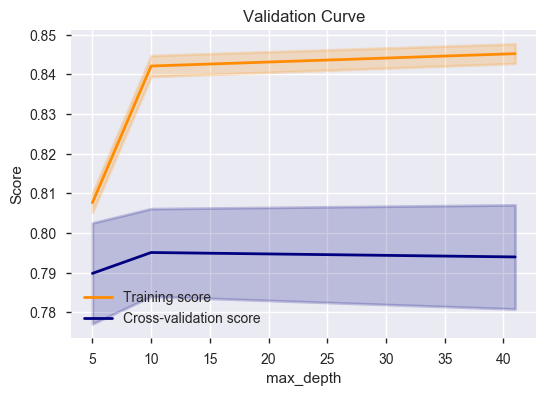

In [78]:
plt.figure(figsize=(6, 4))
param_range=np.array([5, 10, 41])
train_scores, test_scores = validation_curve(forest1, X_train_rf, y_train_rf, param_name="max_depth",
                                             param_range=param_range, cv=5, scoring="roc_auc", n_jobs=-1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve")
plt.xlabel("max_depth")
plt.ylabel("Score")
#plt.ylim(0.0, 1.1)
lw = 2
plt.plot(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.plot(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

Заметно, что глубина 10 - примерно оптимум. Меньшая глубина недостаточна для моделирования данных, большая приводит к переобучению.

## Выводы

Было выяснено, что RandomForestClassifier хорошо работает для имеющихся у нас данных. Получение высокого значения roc_auc значит, что можно выбрать такой порог принятия решений, что можно отобрать людей, которые с высокой вероятностью дадут положительный отклик на маркетинговую кампанию.

Естественно, есть пути улучшения результатов:
* более точная настройка параметров модели;
* использование других моделей;
* сбор большего объёма данных;
* аккуратный feature engineering;